In [ ]:
import numpy as np
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import time
from tqdm import tqdm

# Hàm đánh giá mô hình
def evaluate_model(model, test_questions, test_answers, test_fruit_classifier, test_fruit_regression, tokenizer, max_length, decoder_seq_length):
    print(f"\nĐánh giá mô hình: {model.name}")
    bleu_scores = []
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = []

    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    start_token = tokenizer.word_index["<start>"]
    end_token = tokenizer.word_index["<end>"]

    # Sử dụng tqdm cho vòng lặp qua các mẫu kiểm tra
    for i in tqdm(range(len(test_questions)), desc="Xử lý các mẫu kiểm tra"):
        question_padded = test_questions[i:i+1]
        fruit_classifier_input = test_fruit_classifier[i:i+1]
        fruit_regression_input = test_fruit_regression[i:i+1]
        decoder_input = np.zeros((1, decoder_seq_length))
        decoder_input[0, 0] = start_token

        output_sentence = []
        # Sử dụng tqdm cho vòng lặp sinh token (nếu muốn chi tiết hơn)
        for t in range(decoder_seq_length):
            predictions = model.predict(
                [question_padded, fruit_classifier_input, fruit_regression_input, decoder_input],
                verbose=0
            )
            predicted_id = np.argmax(predictions[0, t, :])
            if predicted_id == end_token:
                break
            output_sentence.append(predicted_id)
            if t < decoder_seq_length - 1:
                decoder_input[0, t + 1] = predicted_id

        predicted_text = [reverse_word_index[idx] for idx in output_sentence if idx in reverse_word_index]
        ground_truth = [reverse_word_index[idx] for idx in test_answers[i] if idx in reverse_word_index and idx != end_token]

        bleu = sentence_bleu([ground_truth], predicted_text)
        bleu_scores.append(bleu)

        rouge = rouge_scorer_obj.score(" ".join(ground_truth), " ".join(predicted_text))
        rouge_scores.append(rouge['rouge1'].fmeasure)

    avg_bleu = np.mean(bleu_scores)
    avg_rouge = np.mean(rouge_scores)
    print(f"\nKết quả trung bình cho {model.name}:")
    print(f"  Average BLEU: {avg_bleu:.4f}")
    print(f"  Average ROUGE-1: {avg_rouge:.4f}")
    return avg_bleu, avg_rouge

# Hàm đo thời gian dự đoán
def measure_time(model, inputs, iterations=100):
    print(f"\nĐo thời gian dự đoán cho mô hình: {model.name}")
    start_time = time.time()
    # Sử dụng tqdm cho vòng lặp đo thời gian
    for _ in tqdm(range(iterations), desc="Dự đoán lặp"):
        model.predict(inputs, verbose=0)
    total_time = time.time() - start_time
    avg_time = total_time / iterations
    print(f"Tổng thời gian: {total_time:.4f} giây")
    print(f"Thời gian trung bình mỗi dự đoán: {avg_time:.4f} giây")
    return avg_time

# Load dữ liệu và chia tập kiểm tra
print("Đang load dữ liệu...")
question_padded = np.load("seq2seqData/question_padded.npy")
answer_padded = np.load("seq2seqData/answer_padded.npy")
image_features = np.load("seq2seqData/image_features.npy")
print(f"Shape của question_padded: {question_padded.shape}")
print(f"Shape của answer_padded: {answer_padded.shape}")
print(f"Shape của image_features: {image_features.shape}")

print("Chia tập kiểm tra...")
_, test_qs, _, test_as, _, test_imgs = train_test_split(
    question_padded, answer_padded, image_features, test_size=0.2, random_state=42
)
test_fruit_classifier = test_imgs[:, :11]
test_fruit_regression = test_imgs[:, 11:]
print(f"Shape của test_qs: {test_qs.shape}")
print(f"Shape của test_as: {test_as.shape}")
print(f"Shape của test_imgs: {test_imgs.shape}")

# Load tokenizer
print("Đang load tokenizer...")
with open("seq2seqData/tokenizer.json", "r", encoding="utf-8") as f:
    tokenizer = tokenizer_from_json(f.read())
print(f"Số từ trong tokenizer: {len(tokenizer.word_index)}")

# Load mô hình
print("Đang load mô hình...")
attention_model = tf.keras.models.load_model("seq2seq_with_attention.keras")
no_attention_model = tf.keras.models.load_model("seq2seq_no_attention.keras")

# Tham số
max_length = 11
decoder_seq_length = max_length - 1

# Đánh giá hiệu suất
print("\n--- Bắt đầu đánh giá hiệu suất ---")
bleu_att, rouge_att = evaluate_model(attention_model, test_qs, test_as, test_fruit_classifier, test_fruit_regression, tokenizer, max_length, decoder_seq_length)
bleu_no_att, rouge_no_att = evaluate_model(no_attention_model, test_qs, test_as, test_fruit_classifier, test_fruit_regression, tokenizer, max_length, decoder_seq_length)

# Đo thời gian dự đoán
print("\n--- Bắt đầu đo thời gian dự đoán ---")
sample_inputs = [test_qs[0:1], test_fruit_classifier[0:1], test_fruit_regression[0:1], np.zeros((1, decoder_seq_length))]
time_att = measure_time(attention_model, sample_inputs)
time_no_att = measure_time(no_attention_model, sample_inputs)

# Lưu kết quả
metrics = {
    "Model": ["Attention", "No Attention"],
    "BLEU": [bleu_att, bleu_no_att],
    "ROUGE-1": [rouge_att, rouge_no_att],
    "Time (s)": [time_att, time_no_att]
}

print("\n--- Kết quả cuối cùng ---")
for i in range(len(metrics["Model"])):
    print(f"Mô hình: {metrics['Model'][i]}")
    print(f"  BLEU: {metrics['BLEU'][i]:.4f}")
    print(f"  ROUGE-1: {metrics['ROUGE-1'][i]:.4f}")
    print(f"  Time (s): {metrics['Time (s)'][i]:.4f}")

Đang load dữ liệu...
Shape của question_padded: (27472, 11)
Shape của answer_padded: (27472, 11)
Shape của image_features: (27472, 12)
Chia tập kiểm tra...
Shape của test_qs: (5495, 11)
Shape của test_as: (5495, 11)
Shape của test_imgs: (5495, 12)
Đang load tokenizer...
Số từ trong tokenizer: 151
Đang load mô hình...

--- Bắt đầu đánh giá hiệu suất ---

Đánh giá mô hình: functional


Xử lý các mẫu kiểm tra: 100%|██████████| 5495/5495 [41:23<00:00,  2.21it/s]



Kết quả trung bình cho functional:
  Average BLEU: 0.4191
  Average ROUGE-1: 0.8560

Đánh giá mô hình: functional_35


Xử lý các mẫu kiểm tra: 100%|██████████| 5495/5495 [41:41<00:00,  2.20it/s]



Kết quả trung bình cho functional_35:
  Average BLEU: 0.4496
  Average ROUGE-1: 0.8621

--- Bắt đầu đo thời gian dự đoán ---

Đo thời gian dự đoán cho mô hình: functional


Dự đoán lặp: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


Tổng thời gian: 8.5289 giây
Thời gian trung bình mỗi dự đoán: 0.0853 giây

Đo thời gian dự đoán cho mô hình: functional_35


Dự đoán lặp: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]

Tổng thời gian: 8.1719 giây
Thời gian trung bình mỗi dự đoán: 0.0817 giây

--- Kết quả cuối cùng ---
Mô hình: Attention
  BLEU: 0.4191
  ROUGE-1: 0.8560
  Time (s): 0.0853
Mô hình: No Attention
  BLEU: 0.4496
  ROUGE-1: 0.8621
  Time (s): 0.0817



--- Vẽ biểu đồ so sánh ---


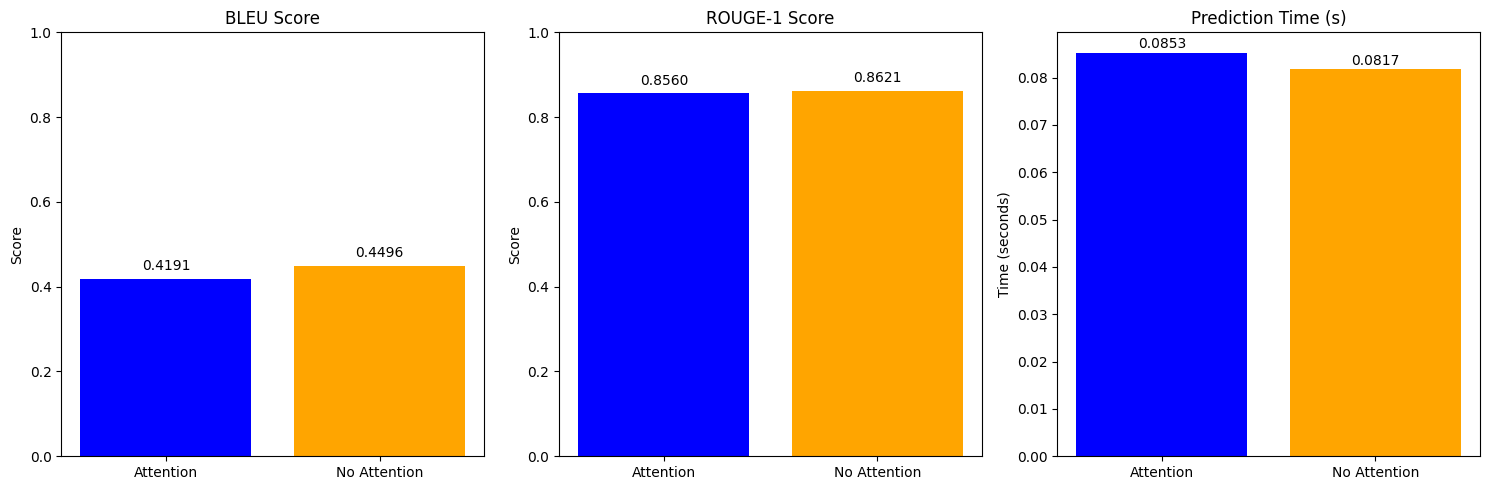

In [14]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ so sánh
print("\n--- Vẽ biểu đồ so sánh ---")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Biểu đồ BLEU Score
ax1.bar(metrics["Model"], metrics["BLEU"], color=['blue', 'orange'])
ax1.set_title("BLEU Score")
ax1.set_ylim(0, 1)
ax1.set_ylabel("Score")
for i, v in enumerate(metrics["BLEU"]):
    ax1.text(i, v + 0.02, f"{v:.4f}", ha='center')

# Biểu đồ ROUGE-1 Score
ax2.bar(metrics["Model"], metrics["ROUGE-1"], color=['blue', 'orange'])
ax2.set_title("ROUGE-1 Score")
ax2.set_ylim(0, 1)
ax2.set_ylabel("Score")
for i, v in enumerate(metrics["ROUGE-1"]):
    ax2.text(i, v + 0.02, f"{v:.4f}", ha='center')

# Biểu đồ Thời gian dự đoán
ax3.bar(metrics["Model"], metrics["Time (s)"], color=['blue', 'orange'])
ax3.set_title("Prediction Time (s)")
ax3.set_ylabel("Time (seconds)")
for i, v in enumerate(metrics["Time (s)"]):
    ax3.text(i, v + 0.001, f"{v:.4f}", ha='center')

# Điều chỉnh layout và hiển thị
plt.tight_layout()
plt.show()